In [ ]:
import requests
import json
import requests
from bs4 import BeautifulSoup
import re
import time
import requests
import re
from bs4 import BeautifulSoup
"""
    从股城网获取A股股票代码 共3687个唯一股票代码
"""
url = "https://hq.gucheng.com/gpdmylb.html" # 股城网沪深
headers = {
    "User-Agent":":Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
}
response = requests.get(url, headers=headers)
response.raise_for_status()
response.encoding = "UTF-8"
# time.sleep(3)
text_1 = response.text
soup = BeautifulSoup(text_1, 'html.parser')
a = soup.find_all('a')      # 获取标签a
list1 = []
for i in a:
    try:
        href = i.attrs['href']       # 获取标签属性href，股票代码都存放在href标签中
        list1.append(re.findall(r"[S][HZ]\d{6}", href)[0])
        # list1.append(i)
    except:
        continue
slist = list(set(list1))


In [ ]:
import pymysql
"""
    在数据库中批量创建股票数据表，每个表分别对应着一支股票
    每个数据表包括日期,股票代码,名称,收盘价,最高价,最低价,开盘价,涨跌额,涨跌幅,成交量,成交金额共11列
"""

connection = pymysql.connect(
    host='localhost',
    user='root',
    password='201410101bxp',
    db='Astock'
)
cursor = connection.cursor()
for i in slist:
    sql = """create table stock{}(
    DATE DATE,
    CODE CHAR(10),
    NAME CHAR(15),
    TCLOSE FLOAT(30,10),
    HIGH FLOAT(30,10),
    LOW FLOAT(30,10),
    TOPEN FLOAT(30,10),
    CHG FLOAT(30,10),
    PCHG FLOAT(30,10),
    VOTURNOVER INT,
    VATURNOVER FLOAT(60,20)
    )""".format(i)
    # 创建数据表，列名为：日期,股票代码,名称,收盘价,最高价,最低价,开盘价,涨跌额,涨跌幅,成交量,成交金额
    # print(sql)
    # print(i)
    cursor.execute(sql)
    connection.commit()

In [ ]:
from datetime import datetime, date, timedelta
import csv
"""
    从网易财经上爬取各支股票的历史行情数据（20190101-20201104）,并写入数据库
    由于数据量过于庞大，本程序只选取了近两年的股票数据，
    即使这样，这些数据从爬取到完整写入数据库也用了十几个小时，实际上可以爬取到近五年甚至更多的数据
"""
# session = requests.session()
for i in range(2160,len(slist)):
    # print("i:",i) # 打印当前写入进度
    connection = pymysql.connect(
    host='localhost',
    user='root',
    password='201410101bxp',
    db='Astock'
    )
    cursor = connection.cursor()
    stock_code0 = slist[i]
    stock_codesh = stock_code0.replace("SH", "0")
    stock_codehs = stock_codesh.replace("SZ", "1")
    # latest_date = datetime.date.today()
    # time_str=(date.today() + timedelta(days = -1)).strftime("%Y%m%d")
    url="http://quotes.money.163.com/service/chddata.html?code=" + stock_codehs + "&start=20190101&end=20201104&fields=TCLOSE;HIGH;LOW;TOPEN;CHG;PCHG;VOTURNOVER;VATURNOVER"
    try:
        response = requests.get(url.split('\n')[0],headers=headers)
        response.encoding="gbk"
        response.raise_for_status()
    except:
        time.sleep(60)
        continue

# response.raise_for_status()
    text_2 = (response.text).replace(" ","").split("\n")
    if len(text_2) < 3:
        continue

    # print(text_2,len(text_2))
    # text_3 = text_2[1].split(",")
    # print(text_3)
    for j in range(1,len(text_2)-1):
    # try:
        # print("j:",j)
        text_3 = text_2[j].replace(" ","").split(",")
        if len(text_3) < 2:
            continue
        # print(text_3)
        try:
            date = text_3[0] 
        except:
            date = "0000-00-00"
        try:
            code = str(text_3[1]).replace("'","") 
        except:
            code = ""
        try:
            name = str(text_3[2])
        except:
            name = ""
        try:
            tclose = float(text_3[3]) 
        except:
            tclose = 0.0
        try:
            high = float(text_3[4]) 
        except:
            high = 0.0
        try:
            low = float(text_3[5])
        except:
            low = 0.0
        try:
            topen = float(text_3[6])
        except:
            topen = 0.0
        try:
            chg = float(text_3[7]) 
        except:
            chg = 0.0
        try:
            pchg = float(text_3[8])
        except:
            pchg = 0.0
        try:
            if len(str(voturnover)) > 9:
                voturnover = 0
            else:
                voturnover = int(text_3[9]) 
        except:
            voturnover = 0
        try:
            vaturnover = float(text_3[10]) 
        except:
            vaturnover = 0.0
        data_temp=(date, # 日期
                   code, # 股票代码
                   name, # 股票名称
                   tclose, # 收盘价
                   high, # 最高价
                   low, # 最低价
                   topen,# 开盘价
                   chg, # 涨跌额
                   pchg, # 涨跌幅
                   voturnover, # 成交量
                   vaturnover # 成交金额
        )
        
        try:
            cursor.execute(
                ("insert into stock{}(date,code,name,tclose,high,low,topen,chg,pchg,voturnover,vaturnover) values('%s','%s','%s','%s','%s','%s','%s','%s','%s','%s','%s')".format(stock_code0)) % (data_temp))
            connection.commit()
        except:
            continue
    time.sleep(5)


        

In [12]:
"""
    获取指定日期、股票的交易数据
"""
import pymysql
def s_data(c,t):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    strc=str(c)
    strt="'" + str(t) + "'"
    sql="select * from stock{} where date={}".format(strc,strt)
    try:
        cursor.execute(sql)
        s_d = cursor.fetchall() #接收全部的返回结果；
    except:
        return "error"
    # return s_d
    if not s_d:return "该日期不是交易日！"
    d = s_d[0]
    print("日期："+str(t))
    print("股票代码："+d[1])
    print("股票名称："+d[2])
    print("收盘价：" +str(round(d[3],2)))
    print("最高价：" +str(round(d[4],2)))
    print("最低价：" +str(round(d[5],2)))
    print("开盘价：" +str(round(d[6],2)))
    print("涨跌额：" +str(round(d[7],2)))
    print("涨跌幅：" +str(round(d[8],2))+ "%")
    print("成交量：" +str(int(d[9]))+ "手")
    print("成交额：" +str(round(d[10],2)))
"""
    例如：获得尚荣医疗（sz002551）在2019年6月6日的交易数据
"""
s_data("sz002551","2019-06-06")

日期：2019-06-06
股票代码：002551
股票名称：尚荣医疗
收盘价：4.84
最高价：4.99
最低价：4.82
开盘价：4.97
涨跌额：-0.13
涨跌幅：-2.62%
成交量：3323177手
成交额：16231726.0


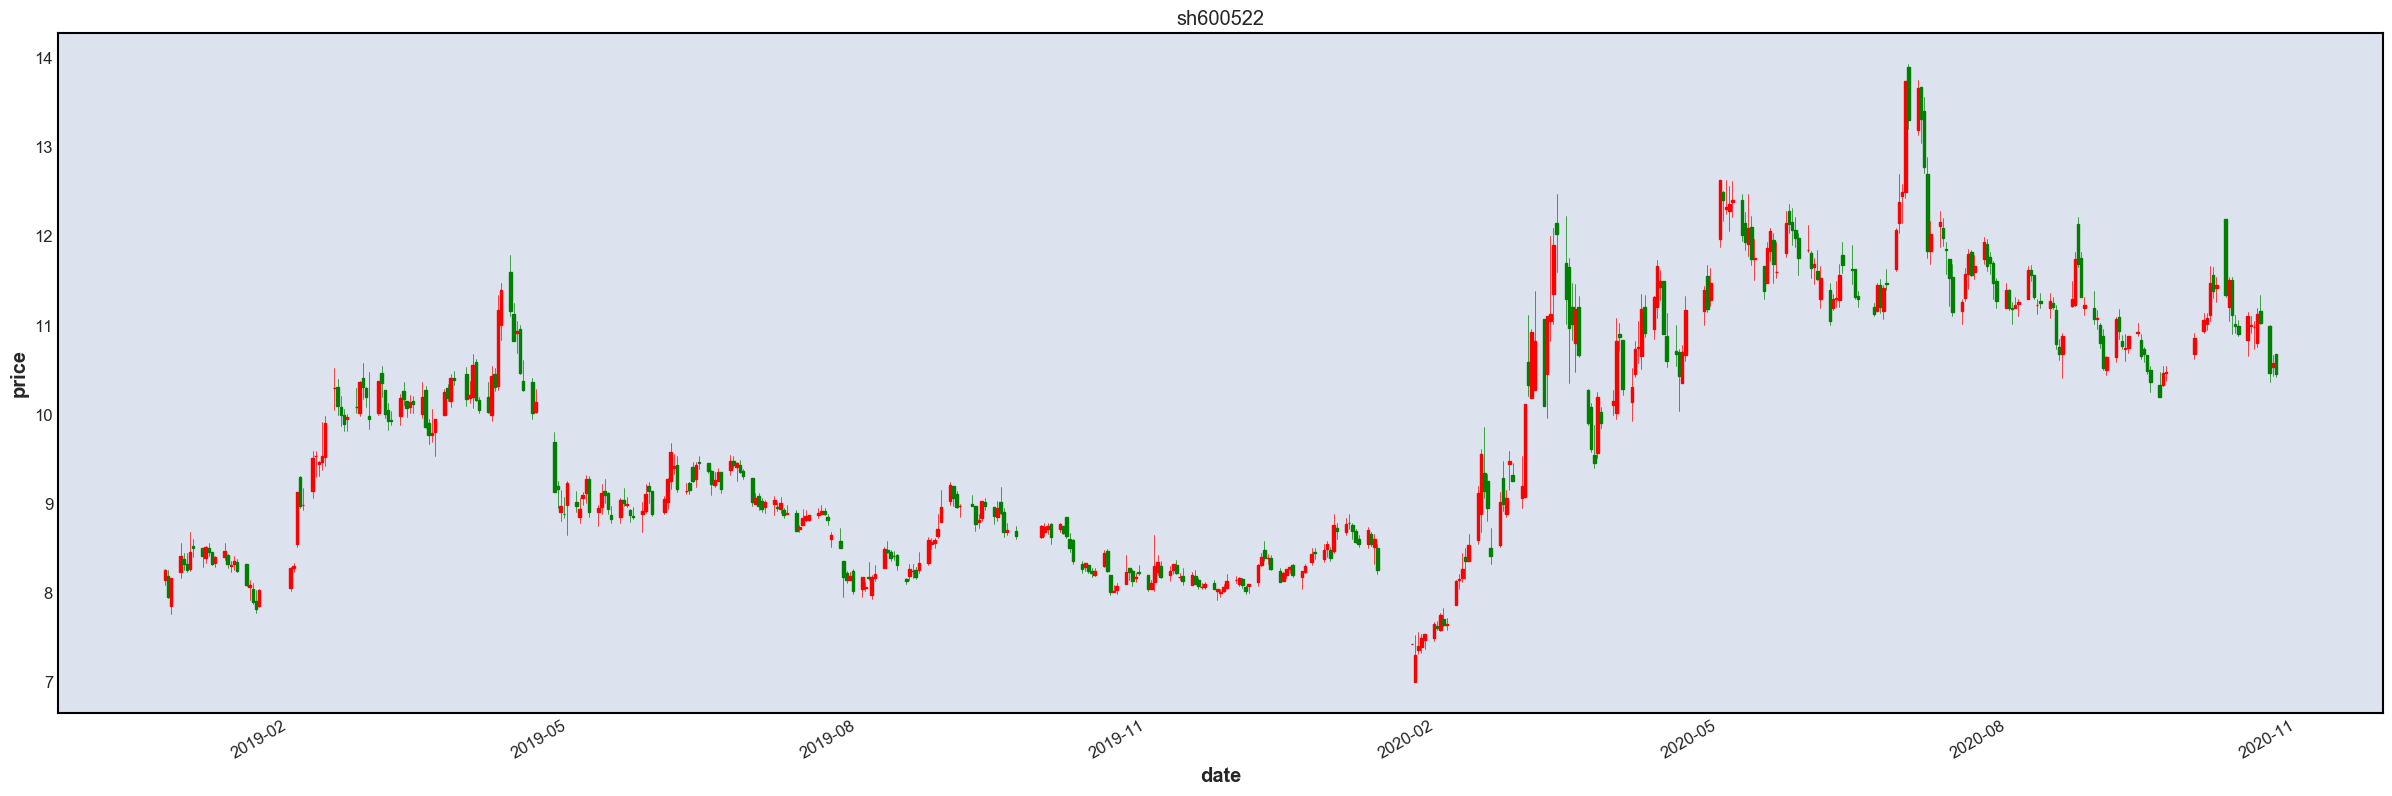

In [177]:
"""
    绘制指定股票的k线图
"""
import pymysql
import matplotlib.pyplot as plt
import mpl_finance as mpf
import pandas as pd
from matplotlib.pylab import date2num 
import datetime

def k_line(c):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    strc=str(c)
    sql = "select date,topen,high,low,tclose from stock{} order by date asc".format(strc)
    try:
        cursor.execute(sql)
        k_d = cursor.fetchall() #接收全部的返回结果；
        # return k_d[0]
    except:
        return "error"
    d = []
    topen = []
    high = []
    low = []
    tclose = []
    for i in range(len(k_d)):
        d.append(k_d[i][0])
        topen.append(round(k_d[i][1],2))
        high.append(round(k_d[i][2],2))
        low.append(round(k_d[i][3],2))
        tclose.append(round(k_d[i][4],2))
    data0 = [d,topen,tclose,high,low]
    data1 = list(zip(*data0))
    kdata = []
    for i in data1:
        kdata.append(list(i))
    # return kdata
    df = pd.DataFrame(kdata,columns=["Date","open","close","high","low"])
#     df['DateTime']=date2num(df['date'].astype(df.date))
#     datetimec = df['DateTime']
#     df.drop('date', axis=1, inplace = True)
#     df.insert(0, 'date', datetimec)
#     df.drop('DateTime', axis=1, inplace = True)
 
#     df.columns = ['t','open', 'high', 'low', 'close']
#     daysreshape = df.reindex(columns=['t','open','high','low','close'])
    df.index.name = "Date"
    df =df.set_index(["Date"])
    data_list = []
    for dates,row in df.iterrows():
        date_time = datetime.datetime.strptime(str(dates), '%Y-%m-%d')
        t = date2num(date_time)
        open, high, close, low = row[:4]
        datas = (t, open, high, low, close)   #tushare里的数据顺序为open,high,close,low注意
        data_list.append(datas)
    
#     fig, ax = plt.subplots(facecolor=(0, 0.3, 0.5),figsize=(16,8))
#     fig.subplots_adjust(bottom=0.1)
#     ax.xaxis_date()
#     plt.xticks(rotation=45) #日期显示的旋转角度
#     plt.title(strc)
#     plt.xlabel('time')
#     plt.ylabel('price')
#     mpf.candlestick_ohlc(ax,data_list,width=1.5,colorup='red',colordown='green',alpha=1) # 上涨为红色K线，下跌为绿色，K线宽度为0.7
#     plt.grid(True)
    fig, ax = plt.subplots(figsize=(30, 10))
    fig.subplots_adjust(bottom=0.2)


    mpf.candlestick_ochl(ax, data_list, width=0.8, colorup='r', colordown='green')
    plt.grid()
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(),rotation=30)
    plt.title(strc)
    plt.xlabel('date')
    plt.ylabel('price')
    plt.show()
"""
    例如：获得sh600522（中天科技）从2019年至今的K线图（双击可放大）
"""
                                             
k_line("sh600522") 

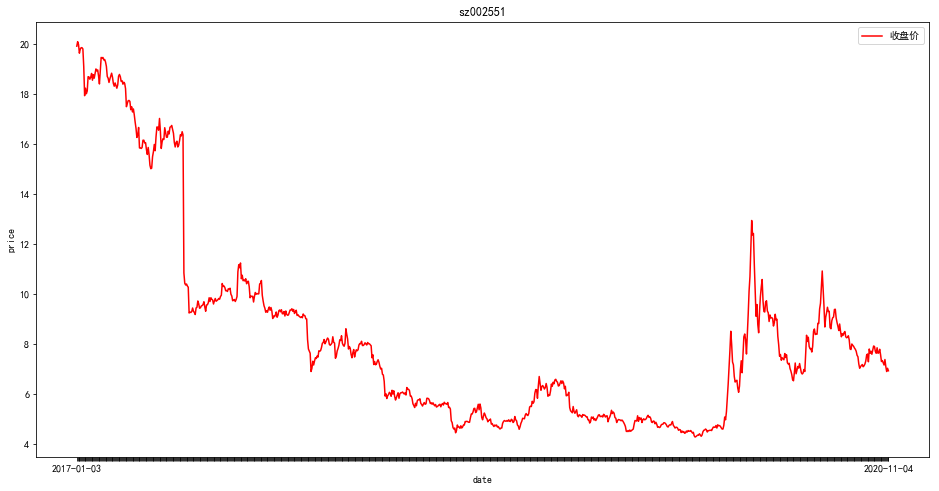

In [21]:
"""
    绘制指定股票收盘价格的走势图
"""
import pymysql
import matplotlib.pyplot as plt

def p_trend(c):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    strc=str(c)
    sql = "select tclose,date,high,low from stock{} order by date asc".format(strc)
    try:
        cursor.execute(sql)
        s_d = cursor.fetchall() #接收全部的返回结果；
        # return s_d
    except:
        return "error"
    y_list = []
    y_listh = []
    y_listl = []
    x_list = []
    for i in range(len(s_d)):
        y_list.append(round(s_d[i][0],2))
        # y_listh.append(round(s_d[i][2],2))
        # y_listl.append(round(s_d[i][3],2))            
        x_list.append("")
    x_list[0]=s_d[0][1]
    x_list[-1]=s_d[-1][1]
    x = range(len(x_list))
    fig = plt.figure(figsize=(16,8))
    plt.plot(x,y_list,color='red', label='收盘价')
    # plt.plot(x,y_listh,color='red', label='最高价')
    # plt.plot(x,y_listl,color='green', label='最低价')
    plt.xticks(x,x_list)
    plt.legend() # 显示图例
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title(strc) #图名
    plt.xlabel("date")#x轴标签
    plt.ylabel("price")#y轴标签
    plt.show()
"""
    例如：绘制sz002551（尚荣医疗）收盘价走势图
"""
        
p_trend("sz002551")
    

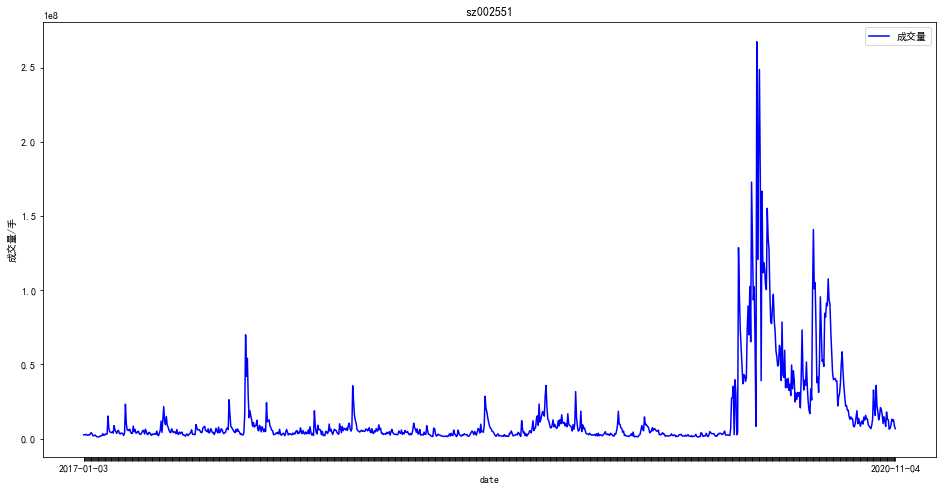

In [26]:
"""
    绘制指定股票成交量的走势图
"""
import pymysql
import matplotlib.pyplot as plt

def q_trend(c):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    strc=str(c)
    sql = "select voturnover,date from stock{} order by date asc".format(strc)
    try:
        cursor.execute(sql)
        s_d = cursor.fetchall() #接收全部的返回结果；
        # return s_d
    except:
        return "error"
    y_list = []
    y_listh = []
    y_listl = []
    x_list = []
    for i in range(len(s_d)):
        y_list.append(round(s_d[i][0],2))
        # y_listh.append(round(s_d[i][2],2))
        # y_listl.append(round(s_d[i][3],2))            
        x_list.append("")
    x_list[0]=s_d[0][1]
    x_list[-1]=s_d[-1][1]
    x = range(len(x_list))
    fig = plt.figure(figsize=(16,8))
    plt.plot(x,y_list,color='blue', label='成交量')
    # plt.plot(x,y_listh,color='red', label='最高价')
    # plt.plot(x,y_listl,color='green', label='最低价')
    plt.xticks(x,x_list)
    plt.legend() # 显示图例
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title(strc) #图名
    plt.xlabel("date")#x轴标签
    plt.ylabel("成交量/手")#y轴标签
    plt.show()
"""
    例如：绘制sz002551（尚荣医疗）成交量走势图
"""
        
q_trend("sz002551")
    

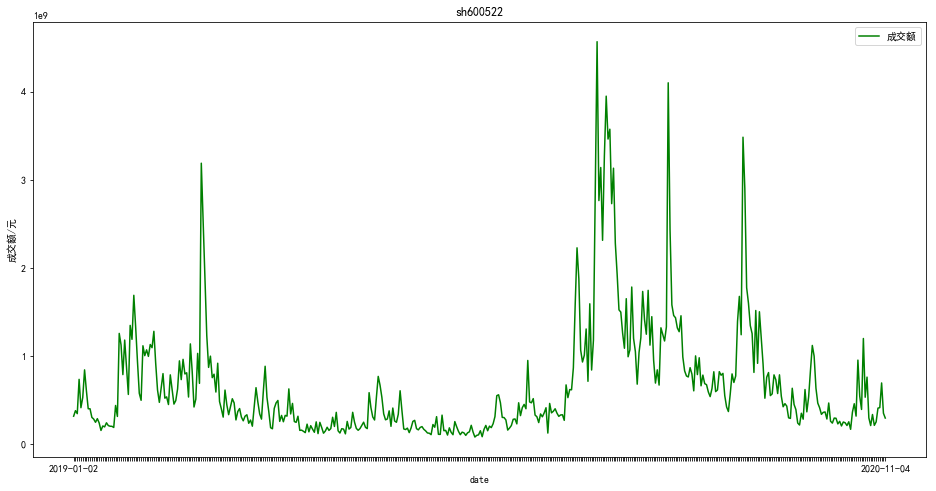

In [27]:
"""
    绘制指定股票成交额的走势图
"""
import pymysql
import matplotlib.pyplot as plt

def a_trend(c):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    strc=str(c)
    sql = "select vaturnover,date from stock{} order by date asc".format(strc)
    try:
        cursor.execute(sql)
        s_d = cursor.fetchall() #接收全部的返回结果；
        # return s_d
    except:
        return "error"
    y_list = []
    y_listh = []
    y_listl = []
    x_list = []
    for i in range(len(s_d)):
        y_list.append(round(s_d[i][0],2))
        # y_listh.append(round(s_d[i][2],2))
        # y_listl.append(round(s_d[i][3],2))            
        x_list.append("")
    x_list[0]=s_d[0][1]
    x_list[-1]=s_d[-1][1]
    x = range(len(x_list))
    fig = plt.figure(figsize=(16,8))
    plt.plot(x,y_list,color='green', label='成交额')
    # plt.plot(x,y_listh,color='red', label='最高价')
    # plt.plot(x,y_listl,color='green', label='最低价')
    plt.xticks(x,x_list)
    plt.legend() # 显示图例
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title(strc) #图名
    plt.xlabel("date")#x轴标签
    plt.ylabel("成交额/元")#y轴标签
    plt.show()
"""
    例如：绘制sh600522（中天科技）成交额走势图
"""
        
a_trend("sh600522")

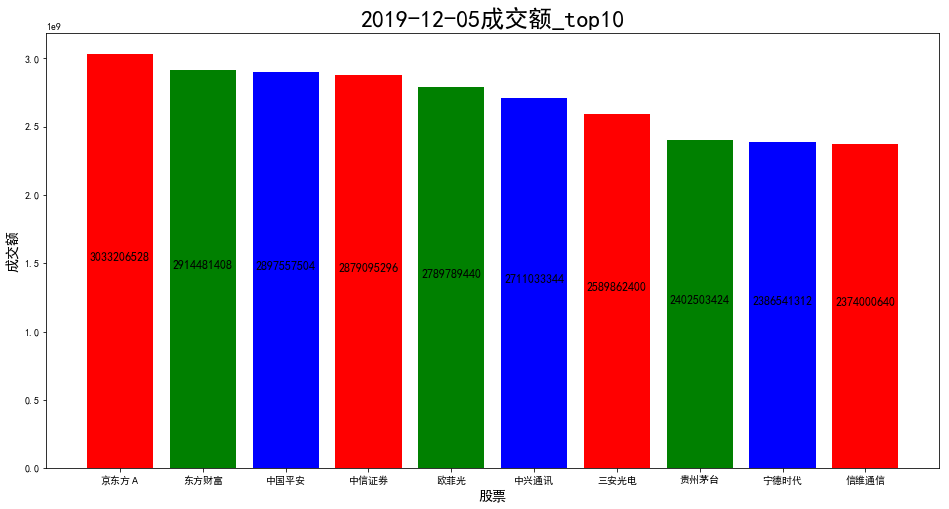

In [61]:
"""
    选取指定日期内成交额最大的10支股票
"""
import pymysql
import matplotlib.pyplot as plt

def a_top10(t):
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    strt="'" +str(t)+ "'"
    sql = "show tables"
    try:
        cursor.execute(sql)
        clist = cursor.fetchall() #接收全部的返回结果；
        # return s_d[0]
    except:
        return "error"
    c_l = []
    c_a = []
    c = {}
    for i in range(len(clist)):
        c_l.append(clist[i][0])
    for j in c_l:
        # print(j)
        sql = "select name,vaturnover from {} where date={}".format(j,strt)
        # print (sql)
        cursor.execute(sql)
        c_a.append(cursor.fetchall()) #接收全部的返回结果
    for i in range(17,len(c_a)):
        if c_a[i]:
            c[str(c_a[i][0][0])]=c_a[i][0][1]
            # print (c_a[i])
        else:
            continue
    # print(c_a[14][0][0], c_a[14][0][1])
    c["深证综指"] = 0
    c["创业板指"] = 0
    d= sorted(c.items(), key=lambda d:d[1], reverse = True)
    x_list=[]
    y_list=[]
    for i in range(10):
        y_list.append(d[i][1])
        x_list.append(d[i][0])
    fig = plt.figure(figsize=(16,8))
    plt.bar(range(len(y_list)), y_list,color='rgb',tick_label=x_list)
    for x,y in enumerate(y_list):
        plt.text(x,y/2,int(y),ha='center',fontsize=12)
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title(str(t)+'成交额_top10',fontsize=24)
    plt.xlabel('股票',fontsize=14)
    plt.ylabel('成交额',fontsize=14)
    plt.show()    
"""
    例如：获取2019年12月5日的成交额最大的十只股票
"""  
a_top10("2019-12-05")

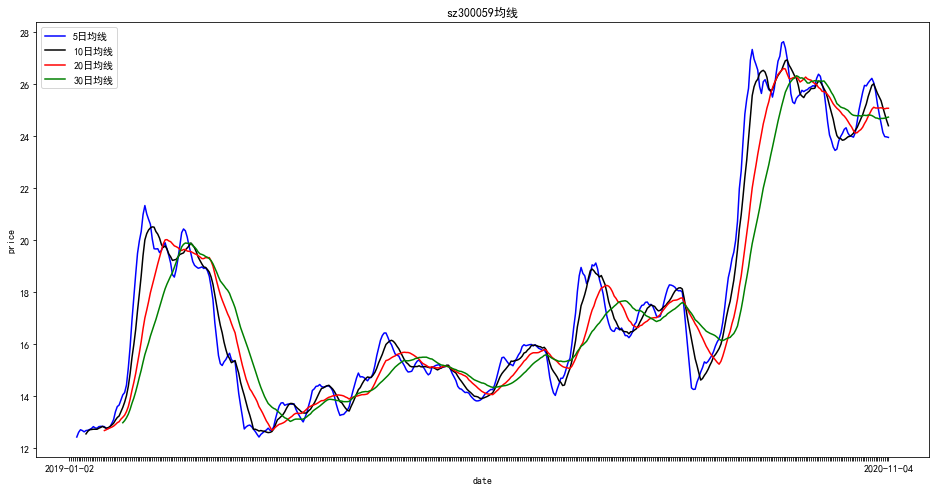

In [75]:
"""
    绘制指定股票的5日、10日、20日、30日均线
"""
import pymysql
import matplotlib.pyplot as plt
import pandas as pd

def l_mean(c):
    strc = str(c)
    connection = pymysql.connect(
        host='localhost',
        user='root',
        password='201410101bxp',
        db='astock'
        )
    cursor = connection.cursor()
    sql = "select date,tclose from stock{} order by date asc".format(strc)
    cursor.execute(sql)
    p_a = cursor.fetchall()
    # return p[0][1]
    d = []
    p = []
    x_l = []
    for i in range(len(p_a)):
        p.append(round(p_a[i][1],2))
        d.append(p_a[i][0])
        x_l.append("")
    x_l[0]=d[0]
    x_l[-1]=d[-1]
    x = range(len(d))
    df = pd.DataFrame(p,index= d,columns=["price"])
    df["m_5"] = round(pd.Series(df["price"]).rolling(window=5).mean(),2)
    df["m_10"] = round(pd.Series(df["price"]).rolling(window=10).mean(),2)
    df["m_20"] = round(pd.Series(df["price"]).rolling(window=20).mean(),2)
    df["m_30"] = round(pd.Series(df["price"]).rolling(window=30).mean(),2)
    # print(df)
    fig = plt.figure(figsize=(16,8))
    plt.plot(x,df["m_5"],color='blue', label='5日均线')
    plt.plot(x,df["m_10"],color='black', label='10日均线')
    plt.plot(x,df["m_20"],color='red', label='20日均线')
    plt.plot(x,df["m_30"],color='green', label='30日均线')
    
    plt.xticks(x,x_l)
    plt.legend() # 显示图例
    plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
    plt.title("{}均线".format(strc)) #图名
    plt.xlabel("date")#x轴标签
    plt.ylabel("price")#y轴标签
    plt.show()
"""
    例如：绘制sz300059（东方财富）的5日、10日、20日、30日均线图
"""
l_mean("sz300059")
    
    